In [1]:
from pathlib import Path
import os
compe='paddy-disease-classification'
iskaggle= os.environ.get('KAGGLE_KERNEL_RUNTYPE','')
if iskaggle:
    path=Path(f'../input/{compe}')
    ! pip install -Uqq fastai
else:
    import kaggle,zipfile
    path=Path(f'{compe}')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████████████████████████████████| 1.02G/1.02G [00:28<00:00, 38.5MB/s]


In [46]:
import torch,torchvision
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision.datasets import DatasetFolder
from PIL import Image

In [15]:
import os
from pathlib import Path
train_path=Path('paddy-disease-classification/train_images')

In [16]:
os.listdir(train_path)

['dead_heart',
 'bacterial_panicle_blight',
 'bacterial_leaf_blight',
 'brown_spot',
 'hispa',
 'downy_mildew',
 'blast',
 'normal',
 'bacterial_leaf_streak',
 'tungro']

In [9]:
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [11]:
auto_transform=weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [43]:
train_dataset=datasets.ImageFolder(train_path,transform=auto_transform)
len(train_dataset)

10407

In [23]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [33]:
def find_classes(directory='paddy-disease-classification/test_images') -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory."""
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [37]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self, 
               targ_dir: list, 
               transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = targ_dir
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes()

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it with three color channels."
    image_path = self.paths[index]
    image = Image.open(image_path)

    # Convert the image to RGB if it has a different mode
    if image.mode != 'RGB':
        image = image.convert('RGB')

    return image

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)
  
  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label

In [28]:
os.listdir('paddy-disease-classification/test_images/bacterial_leaf_blight')

['202919.jpg',
 '200868.jpg',
 '200698.jpg',
 '200840.jpg',
 '201586.jpg',
 '203391.jpg',
 '202931.jpg',
 '202925.jpg',
 '203385.jpg',
 '200854.jpg',
 '201592.jpg',
 '201579.jpg',
 '200667.jpg',
 '202070.jpg',
 '202716.jpg',
 '203408.jpg',
 '200101.jpg',
 '200115.jpg',
 '202702.jpg',
 '202064.jpg',
 '200673.jpg',
 '203352.jpg',
 '200883.jpg',
 '201545.jpg',
 '201223.jpg',
 '203434.jpg',
 '203420.jpg',
 '200129.jpg',
 '201237.jpg',
 '200897.jpg',
 '201551.jpg',
 '203346.jpg',
 '202058.jpg',
 '201960.jpg',
 '201974.jpg',
 '203193.jpg',
 '201784.jpg',
 '201790.jpg',
 '201948.jpg',
 '203187.jpg',
 '202299.jpg',
 '200303.jpg',
 '202514.jpg',
 '202272.jpg',
 '200465.jpg',
 '200471.jpg',
 '202266.jpg',
 '203178.jpg',
 '202500.jpg',
 '201009.jpg',
 '200317.jpg',
 '202528.jpg',
 '201021.jpg',
 '200459.jpg',
 '201747.jpg',
 '203150.jpg',
 '203144.jpg',
 '201753.jpg',
 '201035.jpg',
 '201814.jpg',
 '201800.jpg',
 '201196.jpg',
 '200288.jpg',
 '201828.jpg',
 '201182.jpg',
 '200277.jpg',
 '201169.j

In [53]:
l=[]
for i in range(200001,203470):
    l.append(Path(f'paddy-disease-classification/test_images/bacterial_leaf_blight/{i}.jpg'))
l[:5]

[PosixPath('paddy-disease-classification/test_images/bacterial_leaf_blight/200001.jpg'),
 PosixPath('paddy-disease-classification/test_images/bacterial_leaf_blight/200002.jpg'),
 PosixPath('paddy-disease-classification/test_images/bacterial_leaf_blight/200003.jpg'),
 PosixPath('paddy-disease-classification/test_images/bacterial_leaf_blight/200004.jpg'),
 PosixPath('paddy-disease-classification/test_images/bacterial_leaf_blight/200005.jpg')]

In [54]:
test_data_set_custom = ImageFolderCustom(targ_dir=l,transform=auto_transform)
test_data_set_custom

In [55]:
len(test_data_set_custom)

3469

In [56]:
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
len(train_data_loader)

326

In [57]:
test_data_loader = DataLoader(test_data_set_custom, batch_size=32, shuffle=False)
len(test_data_loader)

109

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


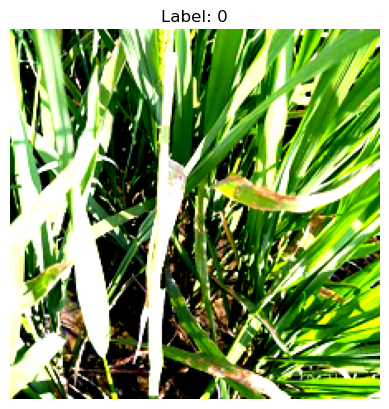

In [67]:
fig = plt.figure()

for images, labels in test_data_loader:
    image = images[3]  # Extract the image from the batch (assuming batch size is 1)
    label = labels[3]  # Extract the label from the batch (assuming batch size is 1)
    print(image.shape)
    # Convert the tensor image to a numpy array and transpose the dimensions
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the normalization applied earlier
    image = 0.5 * image + 0.5

    # Plot the image
    plt.imshow(image)
    plt.title("Label: {}".format(label))
    plt.axis("off")
    plt.show()
    break

In [61]:
from torch import nn

In [62]:
model=torchvision.models.efficientnet_b0(weights=weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [63]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [64]:
import torchinfo

In [68]:
summary=torchinfo.summary(model=model,input_size=(1,3,224,224),
                         col_names=["input_size",
                                    "output_size",
                                    "num_params",
                                    "trainable",],
                          col_width=13,
                          row_settings=['var_names']
                         )
summary

Layer (type (var_name))                                      Input Shape   Output Shape  Param #       Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224] [1, 1000]     --            True
├─Sequential (features)                                      [1, 3, 224, 224] [1, 1280, 7, 7] --            True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224] [1, 32, 112, 112] --            True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224] [1, 32, 112, 112] 864           True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112] [1, 32, 112, 112] 64            True
│    │    └─SiLU (2)                                         [1, 32, 112, 112] [1, 32, 112, 112] --            --
│    └─Sequential (1)                                        [1, 32, 112, 112] [1, 16, 112, 112] --            True
│    │    └─MBConv (0)                                       [1, 32, 112, 112] [1, 16, 

In [69]:
# Freezing sequential layers by keeping req_grad=false for this layers
for params in model.features.parameters():
    params.requires_grad=False

In [70]:
summary2=torchinfo.summary(model=model,input_size=(1,3,224,224),
                         col_names=["input_size",
                                    "output_size",
                                    "num_params",
                                    "trainable",],
                          col_width=13,
                          row_settings=['var_names']
                         )
summary2

Layer (type (var_name))                                      Input Shape   Output Shape  Param #       Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224] [1, 1000]     --            Partial
├─Sequential (features)                                      [1, 3, 224, 224] [1, 1280, 7, 7] --            False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224] [1, 32, 112, 112] --            False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224] [1, 32, 112, 112] (864)         False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112] [1, 32, 112, 112] (64)          False
│    │    └─SiLU (2)                                         [1, 32, 112, 112] [1, 32, 112, 112] --            --
│    └─Sequential (1)                                        [1, 32, 112, 112] [1, 16, 112, 112] --            False
│    │    └─MBConv (0)                                       [1, 32, 112, 112] 

In [71]:
model.classifier=nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,out_features=10)
)

In [72]:
summary3=torchinfo.summary(model=model,input_size=(1,3,224,224),
                         col_names=["input_size",
                                    "output_size",
                                    "num_params",
                                    "trainable",],
                          col_width=13,
                          row_settings=['var_names']
                         )
summary3

Layer (type (var_name))                                      Input Shape   Output Shape  Param #       Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224] [1, 10]       --            Partial
├─Sequential (features)                                      [1, 3, 224, 224] [1, 1280, 7, 7] --            False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224] [1, 32, 112, 112] --            False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224] [1, 32, 112, 112] (864)         False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112] [1, 32, 112, 112] (64)          False
│    │    └─SiLU (2)                                         [1, 32, 112, 112] [1, 32, 112, 112] --            --
│    └─Sequential (1)                                        [1, 32, 112, 112] [1, 16, 112, 112] --            False
│    │    └─MBConv (0)                                       [1, 32, 112, 112] 

In [73]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)

In [74]:
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3842, done.
remote: Counting objects: 100% (485/485), done.
remote: Compressing objects: 100% (274/274), done.
remote: Total 3842 (delta 252), reused 403 (delta 204), pack-reused 3357
Receiving objects: 100% (3842/3842), 650.36 MiB | 29.68 MiB/s, done.
Resolving deltas: 100% (2208/2208), done.
error: unable to write file video_notebooks/07_pytorch_experiment_tracking_video.ipynb
Updating files: 100% (248/248), done.
fatal: unable to checkout working tree
You can inspect what was checked out with 'git status'
and retry with 'git restore --source=HEAD :/'



In [75]:
#Training the model
from going_modular.going_modular import engine
from timeit import default_timer as timer

In [77]:

start_timer=timer()
results=engine.train(model=model,train_dataloader=train_data_loader,test_dataloader=test_data_loader,
                    optimizer=optimizer,loss_fn=loss_fn,epochs=5,device='cpu')
print(f'Total time:{-start_timer+timer()}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5933 | train_acc: 0.4849 | test_loss: 3.5975 | test_acc: 0.0049
Epoch: 2 | train_loss: 1.2374 | train_acc: 0.5988 | test_loss: 3.7545 | test_acc: 0.0215
Epoch: 3 | train_loss: 1.1113 | train_acc: 0.6463 | test_loss: 4.0829 | test_acc: 0.0238
Epoch: 4 | train_loss: 1.0430 | train_acc: 0.6708 | test_loss: 3.9963 | test_acc: 0.0341
Epoch: 5 | train_loss: 1.0076 | train_acc: 0.6717 | test_loss: 4.1493 | test_acc: 0.0330
Total time:8634.216830875


In [78]:
import subprocess
def make_sub(pred_y,sub_data_len=28000,name='default'):
    df_submission = pd.DataFrame()
    df_submission['ImageId']=range(1, sub_data_len+ 1)
    df_submission['Label']=pred_y
    df_submission.to_csv(f'submission-{name}.csv', index=False)
    cmd =f'kaggle competitions submit -c {compe} -f submission-{name}.csv -m "Message"'
    subprocess.run(cmd, shell=True)
    print(f'succesully saved - {name}')

In [79]:
results

{'train_loss': [1.5932618341197264,
  1.2373859734257306,
  1.111273681824924,
  1.0429876358962498,
  1.007634716348414],
 'train_acc': [0.4849364592462752,
  0.5988031332164767,
  0.6462669807186678,
  0.6707931638913234,
  0.6716558939526731],
 'test_loss': [3.5974676718405627,
  3.7544538143577926,
  4.08291728124706,
  3.9962592759263624,
  4.149308731796545],
 'test_acc': [0.004873853211009175,
  0.02150229357798165,
  0.023795871559633027,
  0.03411697247706422,
  0.03297018348623853]}

In [80]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend() 

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();
     

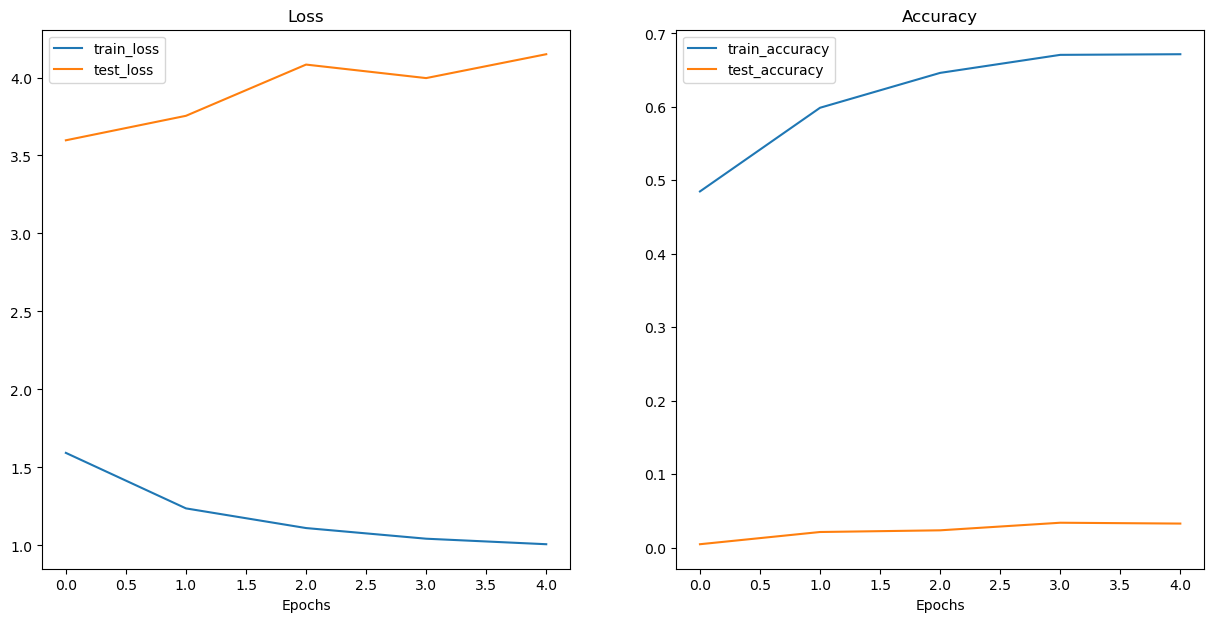

In [81]:
plot_loss_curves(results)

In [83]:
#Building preds loop
EPOCHS=1
all_labes=[]
for epoch in range(EPOCHS):
    model.eval()
    for batch, (X, y) in enumerate(test_data_loader):
        with torch.inference_mode():
            preds_logits=model(X)
            pred_labels = preds_logits.argmax(dim=1)
            lab=pred_labels.numpy()
            all_labes=np.concatenate((all_labes, lab))
#         print(batch)
#         break

In [90]:
all_labes=all_labes.astype(int)
all_labes[:5]

array([7, 8, 6, 3, 3])

In [87]:
classes=train_dataset.class_to_idx
classes

{'bacterial_leaf_blight': 0,
 'bacterial_leaf_streak': 1,
 'bacterial_panicle_blight': 2,
 'blast': 3,
 'brown_spot': 4,
 'dead_heart': 5,
 'downy_mildew': 6,
 'hispa': 7,
 'normal': 8,
 'tungro': 9}

In [100]:
mapped_labels = np.vectorize(lambda x: class_dict[x])(all_labes).astype(str)
mapped_labels[:5]

array(['hispa', 'normal', 'downy_mildew', 'blast', 'blast'], dtype='<U24')

In [94]:
class_dict = {
    0: 'bacterial_leaf_blight',
    1: 'bacterial_leaf_streak',
    2: 'bacterial_panicle_blight',
    3: 'blast',
    4: 'brown_spot',
    5: 'dead_heart',
    6: 'downy_mildew',
    7: 'hispa',
    8: 'normal',
    9: 'tungro'
}

In [102]:
!cd paddy-disease-classification;ls

sample_submission.csv train.csv
test_images           train_images


In [103]:
df=pd.read_csv('paddy-disease-classification/sample_submission.csv')
df

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [104]:
df['label']=mapped_labels

In [105]:
df

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,downy_mildew
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,normal
3466,203467.jpg,normal
3467,203468.jpg,bacterial_leaf_streak


In [106]:
name='starting'
df.to_csv(f'submission-{name}.csv', index=False)
cmd =f'kaggle competitions submit -c {compe} -f submission-{name}.csv -m "Message"'
subprocess.run(cmd, shell=True)
print(f'succesully saved - {name}')

100%|██████████| 69.7k/69.7k [00:00<00:00, 85.4kB/s]


Successfully submitted to Paddy Doctor: Paddy Disease Classificationsuccesully saved - starting
